Cria-se os niveis de enchimento de inicio e de fim. Usa-se a taxa media 3m, ult_valor_obs e ultima_observacao. Quando algum destes valores não existe, preenche-se com a média desse valor por circuito e tipo

In [471]:
import pandas as pd
import numpy as np

In [472]:
df_stats = pd.read_csv("../data/taxas_e_estatisticas.csv", delimiter=';')

In [473]:
#df_stats.info()

In [474]:
df_tabela = pd.read_csv("../data/tabela_observacao_recolha.csv", delimiter=';')

In [475]:
#df_tabela.info()

In [476]:
df_stats = df_stats[['Data', 'Circuito', 'Tipo', 'local_id', 'te_mean_1m', 'te_mean_3m', 'te_median_3m']]

In [477]:
#

In [478]:
#df_tabela

In [479]:
df_tabela['ultima_observacao'] = pd.to_timedelta(df_tabela['ultima_observacao'])
df_tabela['ultima_observacao_horas'] = df_tabela['ultima_observacao'].dt.total_seconds() / 3600

In [480]:
# Calcula a média por Circuito e Tipo
medias = (
    df_tabela
    .groupby(['Circuito', 'Tipo'])['ult_valor_obs']
    .mean()
    .reset_index()
    .rename(columns={'ult_valor_obs': 'media_obs'})
)

# Junta as médias ao DataFrame original
df_tabela = df_tabela.merge(medias, on=['Circuito', 'Tipo'], how='left')

# Preenche NaN com média
df_tabela['ult_valor_obs'] = df_tabela['ult_valor_obs'].fillna(df_tabela['media_obs'])

# Arredonda toda a coluna (agora completa)
df_tabela['ult_valor_obs'] = df_tabela['ult_valor_obs'].round(0).astype(int)

# Remove a coluna auxiliar
df_tabela = df_tabela.drop(columns='media_obs')


In [481]:
# Garante que 'Data' está em formato datetime nos dois DataFrames
df_tabela['Data'] = pd.to_datetime(df_tabela['Data'], dayfirst=True)
df_stats['Data'] = pd.to_datetime(df_stats['Data'], dayfirst=True)

# Faz o merge
df_merged = pd.merge(
    df_tabela,
    df_stats,
    on=['Data', 'Circuito', 'Tipo', 'local_id'],
    how='left'  
)


In [482]:
df_merged

,Data,Circuito,Tipo,local_id,ult_valor_obs,ult_valor_rec,ult_obs_foi_rec,informacao_diaria,recolhido,observacao,ultima_recolha,ultima_observacao,ultima_observacao_horas,te_mean_1m,te_mean_3m,te_median_3m
0,2024-01-02,Circ_Ilhas,Papel,3863,2,NaN,0,NaN,0,1,NaN,NaT,NaN,NaN,NaN,NaN
1,2024-01-02,Circ_Ilhas,Papel,3864,2,NaN,0,NaN,0,1,NaN,NaT,NaN,NaN,NaN,NaN
2,2024-01-02,Circ_Ilhas,Papel,3844,2,NaN,0,2.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN
3,2024-01-02,Circ_Ilhas,Papel,3865,2,NaN,0,4.0,1,1,NaN,NaT,NaN,NaN,NaN,NaN
4,2024-01-02,Circ_Ilhas,Papel,3732,2,NaN,0,NaN,0,1,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362359,2024-12-31,Circuito_12,Vidro,6456,1,NaN,0,NaN,0,0,222 days 11:24:52,2 days 09:53:01,57.883611,0.000000,0.000496,0.0
362360,2024-12-31,Circuito_12,Vidro,4310,1,3.0,0,1.0,0,1,94 days 09:56:49,0 days 08:59:37,8.993611,0.000000,0.001666,0.0
362361,2024-12-31,Circuito_12,Vidro,4370,4,NaN,0,NaN,0,0,3 days 09:44:46,11 days 07:36:37,271.610278,0.003192,0.001368,0.0
362362,2024-12-31,Circuito_12,Vidro,4344,1,NaN,0,NaN,0,0,NaN,61 days 09:08:59,1473.149722,NaN,0.000000,0.0


In [483]:
# Preenche NaNs em ultima_observacao_horas com a MEDIANA por Circuito e Tipo
df_merged['ultima_observacao_horas'] = df_merged.groupby(['Circuito', 'Tipo'])['ultima_observacao_horas'] \
    .transform(lambda x: x.fillna(x.median()))


In [484]:
#df_merged

In [485]:
# Preenche NaNs em te_mean_3m com a mediana por Circuito e Tipo
df_merged['te_median_3m'] = df_merged.groupby(['Circuito', 'Tipo'])['te_median_3m'] \
    .transform(lambda x: x.fillna(x.median()))


In [486]:
# Calcula o nível previsto (nivel_inicio)
df_merged['nivel_inicio'] = (
    df_merged['te_median_3m'] * df_merged['ultima_observacao_horas'] + df_merged['ult_valor_obs']
)

df_merged['nivel_inicio'] = df_merged['nivel_inicio'].round(0).clip(lower=1, upper=5)


In [487]:
#df_tabela

In [488]:
df_merged

,Data,Circuito,Tipo,local_id,ult_valor_obs,ult_valor_rec,ult_obs_foi_rec,informacao_diaria,recolhido,observacao,ultima_recolha,ultima_observacao,ultima_observacao_horas,te_mean_1m,te_mean_3m,te_median_3m,nivel_inicio
0,2024-01-02,Circ_Ilhas,Papel,3863,2,NaN,0,NaN,0,1,NaN,NaT,207.667778,NaN,NaN,0.010495,4.0
1,2024-01-02,Circ_Ilhas,Papel,3864,2,NaN,0,NaN,0,1,NaN,NaT,207.667778,NaN,NaN,0.010495,4.0
2,2024-01-02,Circ_Ilhas,Papel,3844,2,NaN,0,2.0,0,1,NaN,NaT,207.667778,NaN,NaN,0.010495,4.0
3,2024-01-02,Circ_Ilhas,Papel,3865,2,NaN,0,4.0,1,1,NaN,NaT,207.667778,NaN,NaN,0.010495,4.0
4,2024-01-02,Circ_Ilhas,Papel,3732,2,NaN,0,NaN,0,1,NaN,NaT,207.667778,NaN,NaN,0.010495,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362359,2024-12-31,Circuito_12,Vidro,6456,1,NaN,0,NaN,0,0,222 days 11:24:52,2 days 09:53:01,57.883611,0.000000,0.000496,0.000000,1.0
362360,2024-12-31,Circuito_12,Vidro,4310,1,3.0,0,1.0,0,1,94 days 09:56:49,0 days 08:59:37,8.993611,0.000000,0.001666,0.000000,1.0
362361,2024-12-31,Circuito_12,Vidro,4370,4,NaN,0,NaN,0,0,3 days 09:44:46,11 days 07:36:37,271.610278,0.003192,0.001368,0.000000,4.0
362362,2024-12-31,Circuito_12,Vidro,4344,1,NaN,0,NaN,0,0,NaN,61 days 09:08:59,1473.149722,NaN,0.000000,0.000000,1.0


In [489]:
df_merged['nivel_fim'] = df_merged['informacao_diaria'].fillna(df_merged['nivel_inicio'])


In [490]:
df_merged

,Data,Circuito,Tipo,local_id,ult_valor_obs,ult_valor_rec,ult_obs_foi_rec,informacao_diaria,recolhido,observacao,ultima_recolha,ultima_observacao,ultima_observacao_horas,te_mean_1m,te_mean_3m,te_median_3m,nivel_inicio,nivel_fim
0,2024-01-02,Circ_Ilhas,Papel,3863,2,NaN,0,NaN,0,1,NaN,NaT,207.667778,NaN,NaN,0.010495,4.0,4.0
1,2024-01-02,Circ_Ilhas,Papel,3864,2,NaN,0,NaN,0,1,NaN,NaT,207.667778,NaN,NaN,0.010495,4.0,4.0
2,2024-01-02,Circ_Ilhas,Papel,3844,2,NaN,0,2.0,0,1,NaN,NaT,207.667778,NaN,NaN,0.010495,4.0,2.0
3,2024-01-02,Circ_Ilhas,Papel,3865,2,NaN,0,4.0,1,1,NaN,NaT,207.667778,NaN,NaN,0.010495,4.0,4.0
4,2024-01-02,Circ_Ilhas,Papel,3732,2,NaN,0,NaN,0,1,NaN,NaT,207.667778,NaN,NaN,0.010495,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362359,2024-12-31,Circuito_12,Vidro,6456,1,NaN,0,NaN,0,0,222 days 11:24:52,2 days 09:53:01,57.883611,0.000000,0.000496,0.000000,1.0,1.0
362360,2024-12-31,Circuito_12,Vidro,4310,1,3.0,0,1.0,0,1,94 days 09:56:49,0 days 08:59:37,8.993611,0.000000,0.001666,0.000000,1.0,1.0
362361,2024-12-31,Circuito_12,Vidro,4370,4,NaN,0,NaN,0,0,3 days 09:44:46,11 days 07:36:37,271.610278,0.003192,0.001368,0.000000,4.0,4.0
362362,2024-12-31,Circuito_12,Vidro,4344,1,NaN,0,NaN,0,0,NaN,61 days 09:08:59,1473.149722,NaN,0.000000,0.000000,1.0,1.0


In [491]:
df_merged = df_merged[['Data', 'Circuito', 'Tipo', 'local_id', 'nivel_inicio', 'nivel_fim']]

In [492]:
df_merged

,Data,Circuito,Tipo,local_id,nivel_inicio,nivel_fim
0,2024-01-02,Circ_Ilhas,Papel,3863,4.0,4.0
1,2024-01-02,Circ_Ilhas,Papel,3864,4.0,4.0
2,2024-01-02,Circ_Ilhas,Papel,3844,4.0,2.0
3,2024-01-02,Circ_Ilhas,Papel,3865,4.0,4.0
4,2024-01-02,Circ_Ilhas,Papel,3732,4.0,4.0
...,...,...,...,...,...,...
362359,2024-12-31,Circuito_12,Vidro,6456,1.0,1.0
362360,2024-12-31,Circuito_12,Vidro,4310,1.0,1.0
362361,2024-12-31,Circuito_12,Vidro,4370,4.0,4.0
362362,2024-12-31,Circuito_12,Vidro,4344,1.0,1.0


In [447]:
df_merged.to_csv("../data/niveis_inicio_fim.csv", index=False)

### Other 

In [268]:
# Garante que 'Data' está em formato datetime nos dois DataFrames
df_tabela['Data'] = pd.to_datetime(df_tabela['Data'], dayfirst=True)
df_stats['Data'] = pd.to_datetime(df_stats['Data'], dayfirst=True)



In [325]:
#df_merged

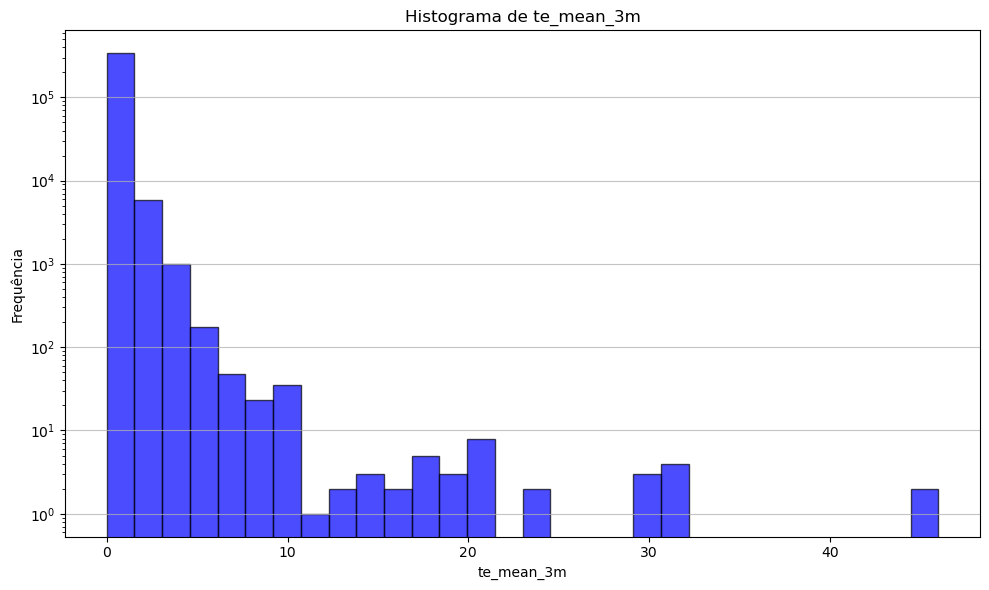

In [321]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df_merged['te_mean_3m'], bins=30, alpha=0.7, color='blue', edgecolor='black')

plt.title('Histograma de te_mean_3m')
plt.xlabel('te_mean_3m')
plt.ylabel('Frequência')
plt.yscale('log')  # escala logarítmica no eixo y
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()



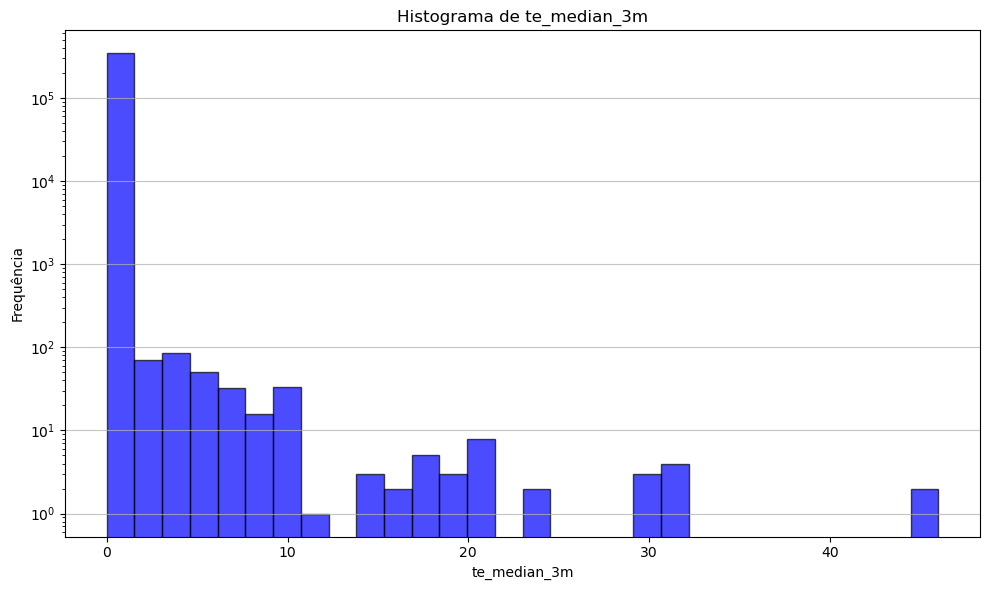

In [323]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df_merged['te_median_3m'], bins=30, alpha=0.7, color='blue', edgecolor='black')

plt.title('Histograma de te_median_3m')
plt.xlabel('te_median_3m')
plt.ylabel('Frequência')
plt.yscale('log')  # escala logarítmica no eixo y
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


In [353]:
valores

888       3.0
891       1.0
1428      0.0
1451      1.0
1454      1.0
         ... 
362359    1.0
362360    1.0
362361    4.0
362362    1.0
362363    1.0
Name: nivel_inicio, Length: 345273, dtype: float64

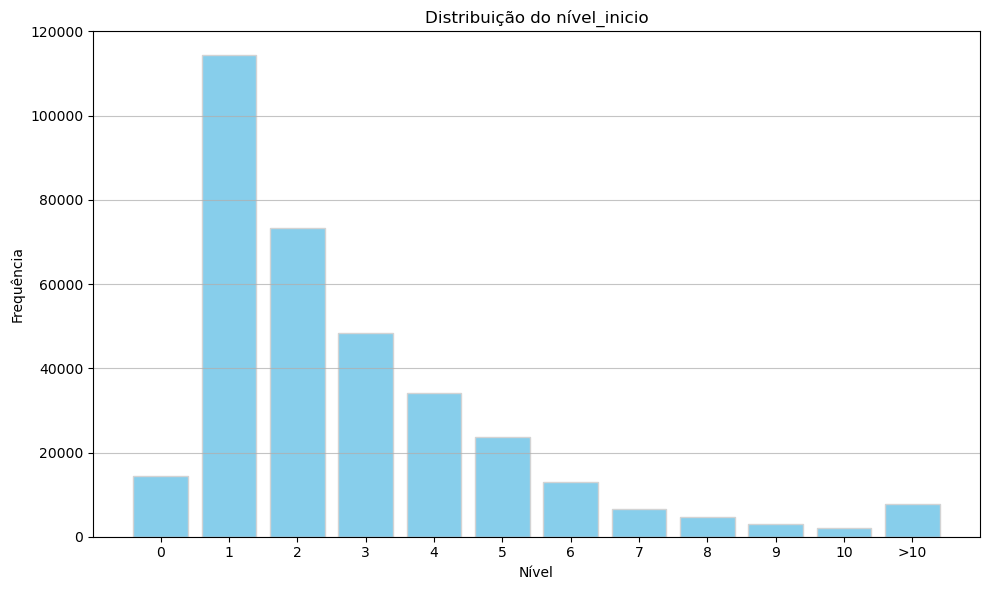

In [372]:
##MEDIANA

import matplotlib.pyplot as plt
import numpy as np

valores = df_merged['nivel_inicio'].dropna()

# Criar categorias: 0,1,2,3,4,5 e >5
categorias = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '>10']

# Contar frequências para cada categoria
frequencias = [
    (valores == 0).sum(),
    (valores == 1).sum(),
    (valores == 2).sum(),
    (valores == 3).sum(),
    (valores == 4).sum(),
    (valores == 5).sum(),
    (valores == 6).sum(),
    (valores == 7).sum(),
    (valores == 8).sum(),
    (valores == 9).sum(),
    (valores == 10).sum(),
    (valores > 10).sum()
]

plt.figure(figsize=(10,6))
plt.bar(categorias, frequencias, color='skyblue', edgecolor='lightgray')

plt.title('Distribuição do nível_inicio')
plt.xlabel('Nível')
plt.ylabel('Frequência')
#plt.yscale('log')  # escala logarítmica no eixo y, se quiser
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()



In [340]:
valores = df_merged['nivel_inicio'].dropna()

entre_0_e_5 = valores[(valores >= 0) & (valores < 6)].count()
maior_que_5 = valores[valores >= 6].count()

print(f'Valores entre 0 e 5: {entre_0_e_5}')
print(f'Valores maiores que 5: {maior_que_5}')


Valores entre 0 e 5: 267208
Valores maiores que 5: 78065


In [341]:
maior_que_5/entre_0_e_5

0.29215068411125417

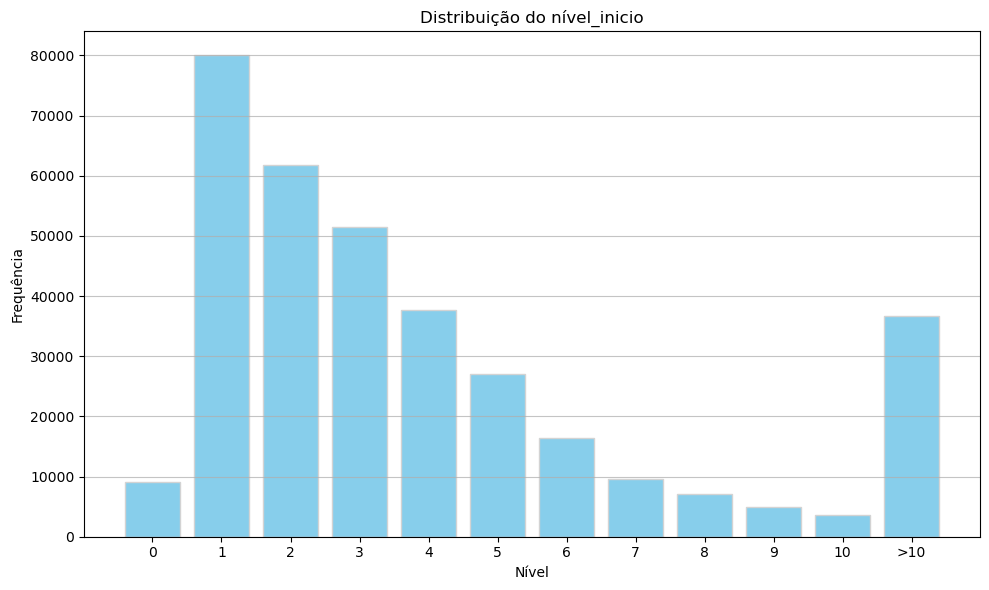

In [396]:
##MEDIA

import matplotlib.pyplot as plt
import numpy as np

valores = df_merged['nivel_inicio'].dropna()

# Criar categorias: 0,1,2,3,4,5 e >5
categorias = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '>10']

# Contar frequências para cada categoria
frequencias = [
    (valores == 0).sum(),
    (valores == 1).sum(),
    (valores == 2).sum(),
    (valores == 3).sum(),
    (valores == 4).sum(),
    (valores == 5).sum(),
    (valores == 6).sum(),
    (valores == 7).sum(),
    (valores == 8).sum(),
    (valores == 9).sum(),
    (valores == 10).sum(),
    (valores > 10).sum()
]

plt.figure(figsize=(10,6))
plt.bar(categorias, frequencias, color='skyblue', edgecolor='lightgray')

plt.title('Distribuição do nível_inicio')
plt.xlabel('Nível')
plt.ylabel('Frequência')
#plt.yscale('log')  # escala logarítmica no eixo y, se quiser
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()



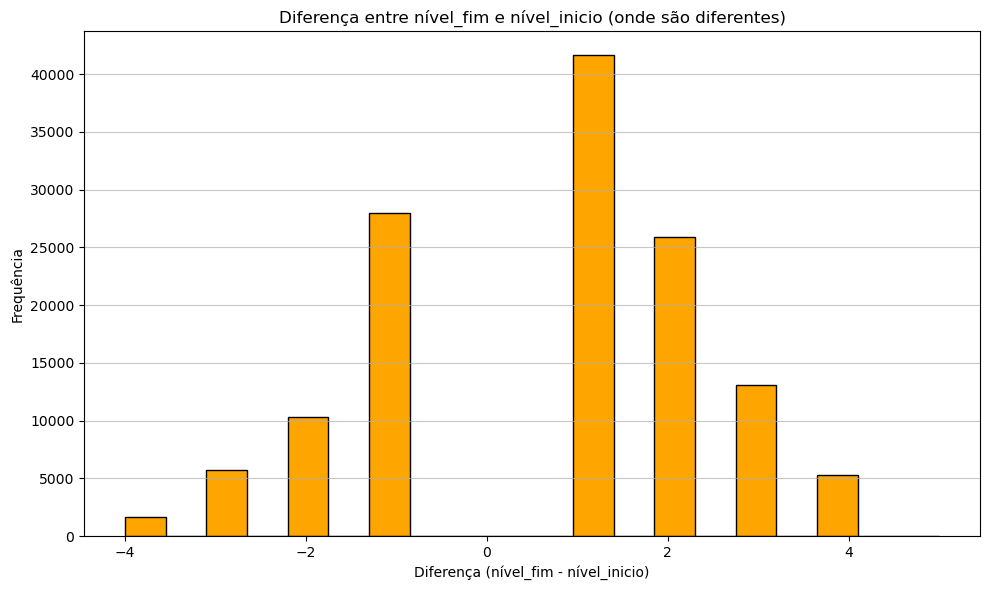

In [470]:
import matplotlib.pyplot as plt

# Filtra os casos em que nivel_inicio é diferente de nivel_fim
df_diff = df_merged[df_merged['nivel_inicio'] != df_merged['nivel_fim']].copy()

# Calcula a diferença
df_diff['diferenca'] = df_diff['nivel_fim'] - df_diff['nivel_inicio']

# Histograma da diferença
plt.figure(figsize=(10,6))
plt.hist(df_diff['diferenca'], bins=20, color='orange', edgecolor='black')

plt.title('Diferença entre nível_fim e nível_inicio (onde são diferentes)')
plt.xlabel('Diferença (nível_fim - nível_inicio)')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()


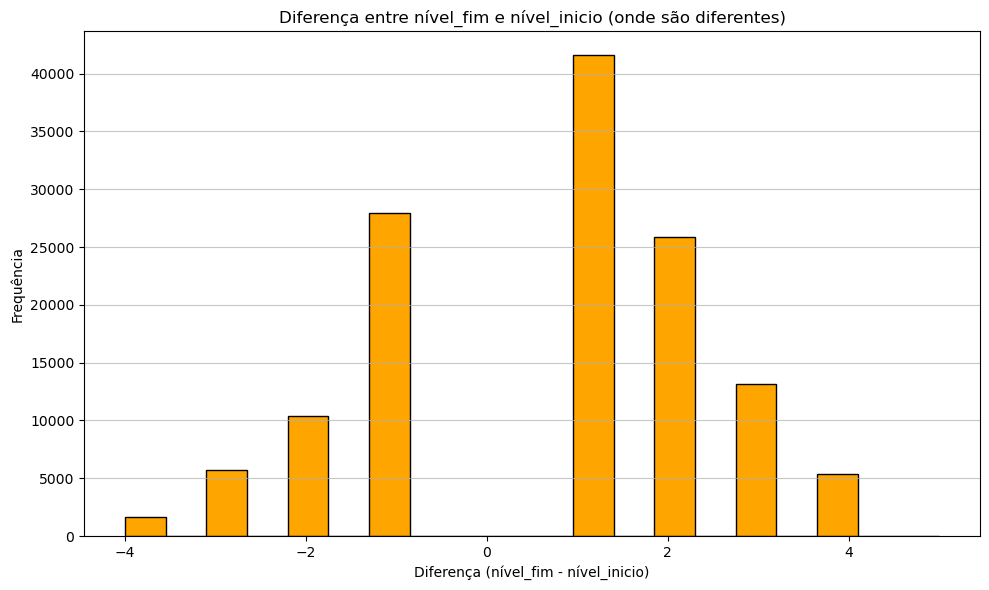

In [493]:
import matplotlib.pyplot as plt

# Filtra os casos em que nivel_inicio é diferente de nivel_fim
df_diff = df_merged[df_merged['nivel_inicio'] != df_merged['nivel_fim']].copy()

# Calcula a diferença
df_diff['diferenca'] = df_diff['nivel_fim'] - df_diff['nivel_inicio']

# Histograma da diferença
plt.figure(figsize=(10,6))
plt.hist(df_diff['diferenca'], bins=20, color='orange', edgecolor='black')

plt.title('Diferença entre nível_fim e nível_inicio (onde são diferentes)')
plt.xlabel('Diferença (nível_fim - nível_inicio)')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()